# Data Exploration: **Do People with Different Ideologies Speak Differently?**


## **Mounting the Google Drive**

It is possible to mount your Google Drive to Colab if you need additional storage or if you need to use files from it. To do that run (click on play button or use keyboard shortcut 'Command/Ctrl+Enter') the following code cell:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.   After running the cell, URL will appear.

2.   Following this URL, you will be redirected to the page where you need to choose Google Drive account to mount to.

3.   You will further be asked to give Google Drive Stream a permission to access the chosen Google account

4.   After granting the access, authorization code will be given to you

5.   Copy the authorization code into the dedicated textbox in Colab under '*Enter your authorization code:*' writing

After copying the authorization code, you should get the message saying '*Mounted at /content/gdrive*'

Path to the files from the mounted Drive will then be '/content/drive/MyDrive/'. By opening the Files tab (left sidebar, folder icon) you should also be able to see the accessible files.

## **Required Libraries**

In [2]:
!pip install pandas==1.3.1
!pip install scipy
!pip install --upgrade scipy
!pip install qwikidata
!pip install empath
!pip install pyLDAvis
!pip install nltk gensim spacy
!python -m spacy download en
!pip install sentence_transformers

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from qwikidata.linked_data_interface import get_entity_dict_from_api
from scipy.stats import bootstrap
from scipy.stats import ttest_ind

#NLP libraries
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from empath import Empath
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models




seed = 42
random.seed(seed)
np.random.seed(seed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## **How to Extract Information From qid**


In [4]:
# Extract information from qid
# from qwikidata.linked_data_interface import get_entity_dict_from_api
def extract_value_from_qid(qid):
  '''
  qid = string
  '''
  q_dict = get_entity_dict_from_api(qid)
  return q_dict['aliases']['en'][0]['value']

In [6]:
extract_value_from_qid('Q6581072')

'woman'

## Sample Topic: **Climate Change**

In [7]:
# Only get quotes that contain key vocabulary related to climate change
# Vocabulary list extracted from https://www.health.state.mn.us/communities/environment/climate/docs/film/vocab_list.pdf
climate_change_data_path = '/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet'
if os.path.exists(climate_change_data_path):
  df_climate_change = pd.read_parquet(climate_change_data_path)
else:
  df['climate_change_voc'] = df['quotation'].str.findall('climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
  fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
  adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma', flags=re.IGNORECASE)
  df_climate_change = df[df['climate_change_voc'].apply(lambda x: len(x)) > 0]
  df_climate_change.to_parquet('/content/drive/MyDrive/Quotebank_Repub_Dem/climate_change_quotes.parquet')

In [8]:
df_climate_change.head()



,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",Male,"[Q82955, Q40348]",Democrat,Julián Castro,0.8279,6947,[ecosystem]
38,2020-03-27-028836,is poised to reverse course on state climate p...,Gavin Newsom,Q461391,"[[Gavin Newsom, 0.7522], [None, 0.2478]]",Male,"[Q82955, Q3427922, Q43845]",Democrat,Gavin Newsom,0.7522,12705,[climate]
142,2020-02-03-092855,"We discussed ways, too, to further improve the...",Mike Pompeo,Q473239,"[[Mike Pompeo, 0.8043], [None, 0.1655], [Abdul...",Male,"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Republican,Mike Pompeo,0.8043,35694,[climate]
157,2020-02-18-014398,cutting off (Venezuelan President Nicolas) Mad...,Mike Pompeo,Q473239,"[[Mike Pompeo, 0.711], [Jorge Arreaza, 0.2204]...",Male,"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Republican,Mike Pompeo,0.7110,35694,[ oil ]
1406,2020-02-07-111676,We will need to work with China to advance som...,Elizabeth Warren,Q434706,"[[Elizabeth Warren, 0.8668], [None, 0.1299], [...",Female,"[Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...",Democrat,Elizabeth Warren,0.8668,36874,[climate]


In [9]:
climate_change_words = 'climate change|ecosystem|habitat|atmosphere|weather|precipitation|climate|global climate|\
fossil fuel| coal | oil |natural gas|greenhouse gas|water vapor|carbon dioxide|methane|ozone|ultraviolet radioation|greenhouse effect|global warming|\
adaptation|mitigation|carbon footprint|renewable resource|extreme weather event|drought|infectious disease|invasive species|pollutant|allergen|asthma'

list_climate_change_words = climate_change_words.split("|")

count_gw_words_dem = {}
count_gw_words_rep = {}
count_gw_words = {}
for word in list_climate_change_words:
    count_gw_words[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x)]['quotation'].count()
    count_gw_words_dem[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == 'Democrat')]['quotation'].count()
    count_gw_words_rep[word] = df_climate_change[df_climate_change["climate_change_voc"].apply(lambda x: word in x) & (df_climate_change["party"] == 'Republican')]['quotation'].count()

df_climate_change_words = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words)})#.sort_values(by='count', ascending=False)
df_climate_change_words_dem = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_dem)})#.sort_values(by='count', ascending=False)
df_climate_change_words_rep = pd.DataFrame({'climate change vocabulary': count_gw_words.keys(), 'count':pd.Series(count_gw_words_rep)})#.sort_values(by='count', ascending=False)

# df_climate_change_words = pd.DataFrame({'count':count_climate_change_words, 'count_rep':count_climate_change_words_rep, 'count_dem':count_climate_change_words_dem})

In [10]:
# Add number of quotations per qid to dataframe (Caution: this column is already aggregated)
df_climate_change['quotationCounts'] = df_climate_change.groupby(['qids'])['quoteID'].transform("count")
n_quotes_qid_df = df_climate_change.drop_duplicates(subset=['qids'])[['party', 'speaker', 'quotationCounts']].sort_values(by='quotationCounts', ascending=False)


In [11]:
df_quotations = pd.DataFrame(df_climate_change['quotation'])

# removing special characters and stop words from the text
stop_words_l=stopwords.words('english')
#remove special characters, remove stop words, and convert everything to lower case
df_quotations['quotations_cleaned']=df_quotations.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )

df_quotations_demo = pd.DataFrame(df_climate_change[df_climate_change['party']=='Democrat']['quotation'])
df_quotations_demo['quotations_cleaned']=df_quotations_demo.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )
df_quotations_rep = pd.DataFrame(df_climate_change[df_climate_change['party']=='Republican']['quotation'])
df_quotations_rep['quotations_cleaned']=df_quotations_rep.quotation.apply(lambda x: " ".join(re.sub(r'[^a-zA-Z]',' ',w).lower() for w in x.split() if re.sub(r'[^a-zA-Z]',' ',w).lower() not in stop_words_l) )


In [12]:
df_quotations.head()

,quotation,quotations_cleaned
17,"Obviously, a message that some people responde...",obviously message people responded well what...
38,is poised to reverse course on state climate p...,poised reverse course state climate policy
142,"We discussed ways, too, to further improve the...",discussed ways too improve business climate ...
157,cutting off (Venezuelan President Nicolas) Mad...,cutting venezuelan president nicolas maduro ...
1406,We will need to work with China to advance som...,need work china advance highest priority natio...


# **NLP Methodologies**

## **Calculating quotes Similarities using different models**

**BERT**

In [13]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

## Aggregating on person level

In [14]:
#number of words in every quotation
words_count = list(df_quotations['quotations_cleaned'].str.split().apply(len))

In [15]:
document_embeddings = sbert_model.encode(list(df_quotations['quotations_cleaned'])).astype(np.float32)

In [16]:
embeddings_df = pd.DataFrame(document_embeddings)
embeddings_df['words_count'] = words_count
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count
0,0.392290,0.362596,1.506887,0.390396,-0.083792,-0.967880,0.010326,-0.028203,0.081313,-0.131849,-0.308205,1.036696,-0.198510,-0.064342,-0.690468,0.594308,-0.530895,-0.626859,-0.007865,-0.375110,0.071739,-0.984709,0.081912,-0.403449,0.864479,-0.335550,-0.322526,-0.506811,-0.792475,0.512030,-0.241799,0.529714,-0.557426,-0.234586,-1.225674,0.798766,1.636289,0.673517,0.095186,0.025802,...,-0.470464,0.118771,-0.184266,0.402645,0.265229,0.391441,0.344368,0.277599,-0.477138,-1.291873,-0.383138,0.360727,-0.278135,-0.551665,-0.213693,1.053849,0.278814,-0.203556,0.205369,0.239032,0.076757,0.324818,-0.538869,0.109057,0.458316,0.335299,0.523931,-0.801941,-0.095170,-0.064166,-0.744371,-0.278051,-1.473776,-0.341439,0.113761,-0.239045,-0.442193,-0.421148,0.430656,28
1,-0.276090,0.059984,0.748883,0.689667,0.430615,-0.071770,0.535857,-0.174377,0.370182,-0.041790,-0.099761,0.034364,-0.086718,0.684485,0.672396,0.017776,-1.381114,0.412645,0.144851,-0.101283,-0.009550,0.275092,-0.345103,-0.220950,0.630575,-0.443851,0.037435,-1.165505,-0.856562,0.292411,-0.442393,0.860950,-0.485955,-0.018936,0.057130,0.658449,-0.363748,-0.088727,-0.180143,0.427678,...,-0.815111,-0.297990,0.202723,-0.064484,0.778803,0.802076,0.525397,0.135449,0.272798,-0.524862,-0.735942,-0.859386,1.220452,-0.204889,0.454963,-0.058292,0.459017,-0.155039,0.173957,-0.623147,0.248971,0.990796,0.736442,0.729479,-0.583250,-0.022556,0.174625,-0.097271,-0.388408,0.236517,-0.108942,-0.092783,0.187574,-0.348918,-0.770271,-0.009358,-1.365222,-0.431023,0.104164,6
2,-0.262492,0.311869,0.160342,0.069163,0.690900,-0.646249,-0.016825,-0.438863,0.247877,-0.926257,0.474024,1.071200,0.139002,0.206347,-1.509502,0.279838,-0.434678,0.450750,-0.181156,0.089227,-0.295112,-0.499409,0.440355,1.611041,1.010058,0.196579,-0.016638,0.661965,-0.777819,0.274797,-0.017135,0.959826,-0.604777,-0.333916,-0.261854,1.271795,0.547384,-0.310361,-0.088402,0.233138,...,-0.339654,0.892052,-0.633574,0.522622,0.480226,-0.341362,0.408706,-0.275880,0.244384,-0.765245,-1.040962,-0.227464,0.504923,-0.082724,-0.133145,0.089076,0.587382,-0.538049,0.172374,0.573811,0.209099,0.388579,-1.488149,1.051013,0.774377,-0.086767,0.986590,-0.077343,0.280939,-0.520410,-0.945611,-0.691763,-0.954207,0.206712,-0.914305,-1.009511,-0.493819,-0.396181,-0.348898,26
3,-0.173631,0.262899,-0.454810,0.490647,0.535360,-0.734528,-0.146519,-0.121214,0.100566,0.168450,-0.207073,0.884184,0.579100,0.253797,-0.528084,0.449425,-0.095694,0.513449,0.253689,-0.216843,-0.738063,0.192891,0.146313,0.621648,0.545283,0.190566,-0.384007,-0.103311,-0.556065,0.595463,0.146289,0.767840,-0.731560,0.133493,0.823824,0.584931,-0.401407,0.131814,-0.228329,-0.396380,...,-0.796681,-0.261922,-0.142453,0.395227,0.194575,1.106904,1.033513,-0.307096,0.007026,-1.202947,-1.595917,-1.367590,0.989817,-0.431020,-0.022003,-0.004638,1.830119,-0.107874,-0.467260,-0.115369,0.415135,0.621610,-1.138309,1.161846,-0.607661,-0.233466,0.626053,0.157353,-0.005124,0.565139,0.128003,-0.577663,-0.596033,0.823745,-0.953657,0.015019,0.140466,-0.214267,0.039831,13
4,-0.232973,0.923275,0.312170,0.428204,0.195382,-1.031741,0.752052,0.171839,0.358599,-0.640962,0.067704,0.175315,0.267779,-0.072377,-0.552851,0.565083,0.168140,0.071761,0.217430,-0.031299,-0.494958,-0.557887,0.265033,0.187148,1.366925,0.123585,0.021434,-0.216149,-0.288605,0.211154,-0.173858,1.100585,-0.919371,-0.314065,-0.053473,1.246847,0.543307,0.480022,0.097977,-0.377781,...,-0.188017,-0.297765,-0.620104,-0.256765,0.125055,0.255995,0.554811,0.113820,0.138856,-0.900987,-0.938395,-0.542258,0.391879,-0.430982,0.051312,0.452928,-0.067167,-0.450576,0.246886,0.093080,0.401223,0.818779,0.487191,0.186521,0.541538,0.148725,1.061945,-0.012466,-0.015277,-0.145145,-0.498284,0.0

In [17]:
embeddings_df['embeddings']= embeddings_df[range(768)].values.tolist()

In [18]:
#embeddings_df = pd.DataFrame(embeddings_df['embeddings'])
embeddings_df['embeddings'] = embeddings_df['embeddings'].apply(lambda x: np.array(x))

In [19]:
df = embeddings_df.merge(right=df_climate_change.reset_index(), how='inner', left_index=True, right_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,embeddings,index,quoteID,quotation,speaker,qids,probas,gender,occupation,party,max_prob_speaker,max_probas,quotationCounts,climate_change_voc
0,0.392290,0.362596,1.506887,0.390396,-0.083792,-0.967880,0.010326,-0.028203,0.081313,-0.131849,-0.308205,1.036696,-0.198510,-0.064342,-0.690468,0.594308,-0.530895,-0.626859,-0.007865,-0.375110,0.071739,-0.984709,0.081912,-0.403449,0.864479,-0.335550,-0.322526,-0.506811,-0.792475,0.512030,-0.241799,0.529714,-0.557426,-0.234586,-1.225674,0.798766,1.636289,0.673517,0.095186,0.025802,...,-0.213693,1.053849,0.278814,-0.203556,0.205369,0.239032,0.076757,0.324818,-0.538869,0.109057,0.458316,0.335299,0.523931,-0.801941,-0.095170,-0.064166,-0.744371,-0.278051,-1.473776,-0.341439,0.113761,-0.239045,-0.442193,-0.421148,0.430656,28,"[0.3922901153564453, 0.36259564757347107, 1.50...",17,2020-01-05-025623,"Obviously, a message that some people responde...",Julián Castro,Q970720,"[[Julián Castro, 0.8279], [None, 0.1651], [Ber...",Male,"[Q82955, Q40348]",Democrat,Julián Castro,0.8279,89,[ecosystem]
1,-0.276090,0.059984,0.748883,0.689667,0.430615,-0.071770,0.535857,-0.174377,0.370182,-0.041790,-0.099761,0.034364,-0.086718,0.684485,0.672396,0.017776,-1.381114,0.412645,0.144851,-0.101283,-0.009550,0.275092,-0.345103,-0.220950,0.630575,-0.443851,0.037435,-1.165505,-0.856562,0.292411,-0.442393,0.860950,-0.485955,-0.018936,0.057130,0.658449,-0.363748,-0.088727,-0.180143,0.427678,...,0.454963,-0.058292,0.459017,-0.155039,0.173957,-0.623147,0.248971,0.990796,0.736442,0.729479,-0.583250,-0.022556,0.174625,-0.097271,-0.388408,0.236517,-0.108942,-0.092783,0.187574,-0.348918,-0.770271,-0.009358,-1.365222,-0.431023,0.104164,6,"[-0.2760896682739258, 0.05998389795422554, 0.7...",38,2020-03-27-028836,is poised to reverse course on state climate p...,Gavin Newsom,Q461391,"[[Gavin Newsom, 0.7522], [None, 0.2478]]",Male,"[Q82955, Q3427922, Q43845]",Democrat,Gavin Newsom,0.7522,298,[climate]
2,-0.262492,0.311869,0.160342,0.069163,0.690900,-0.646249,-0.016825,-0.438863,0.247877,-0.926257,0.474024,1.071200,0.139002,0.206347,-1.509502,0.279838,-0.434678,0.450750,-0.181156,0.089227,-0.295112,-0.499409,0.440355,1.611041,1.010058,0.196579,-0.016638,0.661965,-0.777819,0.274797,-0.017135,0.959826,-0.604777,-0.333916,-0.261854,1.271795,0.547384,-0.310361,-0.088402,0.233138,...,-0.133145,0.089076,0.587382,-0.538049,0.172374,0.573811,0.209099,0.388579,-1.488149,1.051013,0.774377,-0.086767,0.986590,-0.077343,0.280939,-0.520410,-0.945611,-0.691763,-0.954207,0.206712,-0.914305,-1.009511,-0.493819,-0.396181,-0.348898,26,"[-0.26249176263809204, 0.31186896562576294, 0....",142,2020-02-03-092855,"We discussed ways, too, to further improve the...",Mike Pompeo,Q473239,"[[Mike Pompeo, 0.8043], [None, 0.1655], [Abdul...",Male,"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Republican,Mike Pompeo,0.8043,408,[climate]
3,-0.173631,0.262899,-0.454810,0.490647,0.535360,-0.734528,-0.146519,-0.121214,0.100566,0.168450,-0.207073,0.884184,0.579100,0.253797,-0.528084,0.449425,-0.095694,0.513449,0.253689,-0.216843,-0.738063,0.192891,0.146313,0.621648,0.545283,0.190566,-0.384007,-0.103311,-0.556065,0.595463,0.146289,0.767840,-0.731560,0.133493,0.823824,0.584931,-0.401407,0.131814,-0.228329,-0.396380,...,-0.022003,-0.004638,1.830119,-0.107874,-0.467260,-0.115369,0.415135,0.621610,-1.138309,1.161846,-0.607661,-0.233466,0.626053,0.157353,-0.005124,0.565139,0.128003,-0.577663,-0.596033,0.823745,-0.953657,0.015019,0.140466,-0.214267,0.039831,13,"[-0.17363065481185913, 0.26289939880371094, -0...",157,2020-02-18-014398,cutting off (Venezuelan President Nicolas) Mad...,Mike Pompeo,Q473239,"[[Mike Pompeo, 0.711], [Jorge Arreaza, 0.2204]...",Male,"[Q40348, Q43845, Q2961975, Q189290, Q82955]",Republican,Mike Pompeo,0.7110,408,[ oil ]
4,-0.232973

In [20]:
speaker_embeddings = pd.DataFrame(df.groupby(by=['qids']).mean())
speaker_embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts
qids,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Q1026119,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,-0.634840,0.287954,0.567875,0.408779,0.527659,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2.884552e+06,0.867600,4.0
Q1027431,-0.139288,0.534114,0.711473,0.397442,0.056413,-1.074494,-0.136760,0.039398,0.379704,-0.396134,0.494942,0.762402,-0.069404,0.684987,-0.159036,0.228532,-0.750432,0.071208,-0.104787,-0.179867,0.201158,-0.406767,0.279342,0.293721,1.041441,-0.337799,-0.330148,-0.219937,-0.372879,0.486595,-0.231918,1.231402,-0.848282,-0.103732,-0.452112,1.097568,0.109649,-0.206486,0.085525,0.013681,...,0.082170,0.309635,0.688229,0.298405,0.464373,0.050403,-0.738270,-0.815343,-1.163567,0.013827,-0.096368,0.149871,0.155196,0.127399,-0.407436,0.490227,0.064487,0.461822,0.721733,-0.168417,0.503989,0.144336,0.314891,0.593708,-0.035674,0.031647,-0.111204,-0.193139,-0.368645,-0.571929,-0.313652,-0.913563,-0.053436,-0.859550,0.000509,-0.058429,14.428571,4.527037e+06,0.799129,7.0
Q1029527,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037314,0.551603,0.220330,0.390904,-0.333933,0.392253,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034259,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,-0.185251,-0.014267,0.637945,0.819614,0.184619,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251522,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169510,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5.338808e+06,0.855367,6.0
Q10327963,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,-0.187032,0.094840,0.601061,0.365004,0.137652,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3.058824e+06,0.797450,10.0
Q10346298,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,0.128357,-0.219236,0.069907,0.334807,0.366730,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.3644

In [21]:
speaker_embeddings = speaker_embeddings.merge(right=df_climate_change[['speaker', 'party', 'qids']], how='inner', left_index=True, right_on='qids').drop_duplicates(subset=['qids'])
speaker_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts,speaker,party,qids
1040594,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,0.408779,0.527659,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2.884552e+06,0.867600,4.0,Cal Dooley,Democrat,Q1026119
1290135,-0.139288,0.534114,0.711473,0.397442,0.056413,-1.074494,-0.136760,0.039398,0.379704,-0.396134,0.494942,0.762402,-0.069404,0.684987,-0.159036,0.228532,-0.750432,0.071208,-0.104787,-0.179867,0.201158,-0.406767,0.279342,0.293721,1.041441,-0.337799,-0.330148,-0.219937,-0.372879,0.486595,-0.231918,1.231402,-0.848282,-0.103732,-0.452112,1.097568,0.109649,-0.206486,0.085525,0.013681,...,0.298405,0.464373,0.050403,-0.738270,-0.815343,-1.163567,0.013827,-0.096368,0.149871,0.155196,0.127399,-0.407436,0.490227,0.064487,0.461822,0.721733,-0.168417,0.503989,0.144336,0.314891,0.593708,-0.035674,0.031647,-0.111204,-0.193139,-0.368645,-0.571929,-0.313652,-0.913563,-0.053436,-0.859550,0.000509,-0.058429,14.428571,4.527037e+06,0.799129,7.0,Tim Wirth,Democrat,Q1027431
1315818,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037314,0.551603,0.220330,0.390904,-0.333933,0.392253,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034259,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,0.819614,0.184619,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251522,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169510,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5.338808e+06,0.855367,6.0,Steve Womack,Republican,Q1029527
32330,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,0.365004,0.137652,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3.058824e+06,0.797450,10.0,Mead Treadwell,Republican,Q10327963
655115,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,0.334807,0.366730,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.364463,0.482853,0.175077,0.083998,0.671945,-0.329927,0.082321,0.478577,0.203737,0.372819,-0.681629,0.091651

In [22]:
pd.DataFrame(speaker_embeddings.reset_index(inplace=True))
speaker_embeddings.drop(columns='level_0', inplace=True)

In [23]:
#similarity matrix aggregated on person level: shape: n_speakers x n_speakers
speaker_similarity_matrix = cosine_similarity(speaker_embeddings[range(768)])

In [24]:
# similarity matrix between each speaker and the democrats
demo_indices = speaker_embeddings.loc[(speaker_embeddings.party == 'Democrat')].index
rep_indices = speaker_embeddings.loc[(speaker_embeddings.party == 'Republican')].index

In [25]:
# similarity between each speaker and all the democrats 
similarity_with_democrats = speaker_similarity_matrix[:, demo_indices].mean(axis=1)
# similarity between each speaker and all the republicans
similarity_with_republicans = speaker_similarity_matrix[:, rep_indices].mean(axis=1)

In [26]:
# join these two columns to the speaker_embeddings dataframe
speaker_embeddings['similarity_with_democrats'] = similarity_with_democrats
speaker_embeddings['similarity_with_republicans'] = similarity_with_republicans

In [27]:
speaker_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,words_count,index,max_probas,quotationCounts,speaker,party,qids,similarity_with_democrats,similarity_with_republicans
0,-0.536326,0.394520,0.228848,0.167920,0.174588,-1.035974,-0.284449,0.484130,0.439821,-0.690659,0.155084,0.480205,0.388771,0.442856,-0.203715,0.446224,-0.385430,-0.111054,0.183865,-0.336238,-0.164392,-0.680998,0.730367,0.290025,1.138237,0.012076,-0.479029,-0.276269,-0.720881,0.061013,-0.443775,0.789852,-0.570844,-0.368051,-0.086192,1.346207,-0.106367,-0.184372,0.015998,-0.430114,...,-0.162379,-0.809090,-0.444717,-0.735685,0.085757,-0.419947,-0.286361,-0.327894,0.313055,-0.286735,0.178258,-0.257379,0.034853,0.512240,-0.905915,0.449981,0.419267,-0.100765,0.621482,0.179663,0.245936,0.063172,-0.508997,-0.590401,-0.775920,-0.183768,-0.811389,-0.129250,-0.655885,0.075738,-0.289588,18.500000,2.884552e+06,0.867600,4.0,Cal Dooley,Democrat,Q1026119,0.626989,0.621164
1,-0.139288,0.534114,0.711473,0.397442,0.056413,-1.074494,-0.136760,0.039398,0.379704,-0.396134,0.494942,0.762402,-0.069404,0.684987,-0.159036,0.228532,-0.750432,0.071208,-0.104787,-0.179867,0.201158,-0.406767,0.279342,0.293721,1.041441,-0.337799,-0.330148,-0.219937,-0.372879,0.486595,-0.231918,1.231402,-0.848282,-0.103732,-0.452112,1.097568,0.109649,-0.206486,0.085525,0.013681,...,0.050403,-0.738270,-0.815343,-1.163567,0.013827,-0.096368,0.149871,0.155196,0.127399,-0.407436,0.490227,0.064487,0.461822,0.721733,-0.168417,0.503989,0.144336,0.314891,0.593708,-0.035674,0.031647,-0.111204,-0.193139,-0.368645,-0.571929,-0.313652,-0.913563,-0.053436,-0.859550,0.000509,-0.058429,14.428571,4.527037e+06,0.799129,7.0,Tim Wirth,Democrat,Q1027431,0.640303,0.610692
2,0.092411,0.529833,0.566304,0.176370,0.132939,-0.689673,0.275030,0.293705,0.245521,-0.443756,0.037314,0.551603,0.220330,0.390904,-0.333933,0.392253,-0.304860,-0.167685,0.064981,-0.232717,-0.093528,-0.285050,0.429607,0.055496,0.802852,-0.129811,-0.312441,-0.648497,-0.848009,0.433813,-0.148339,0.769624,-0.822453,-0.034259,-0.056678,1.109627,0.104464,0.049776,-0.013674,-0.371102,...,-0.093535,-0.841894,-0.826961,-0.556561,0.028017,-0.375134,-0.198182,0.145947,0.251522,-0.002737,0.340454,0.274044,0.325237,0.757267,-0.172480,0.587076,0.123403,0.029546,0.169510,-0.311977,0.124282,0.075865,-0.286628,-0.345726,-1.023969,-0.079081,-0.767494,-0.118257,-0.394877,-0.432880,0.023874,25.333333,5.338808e+06,0.855367,6.0,Steve Womack,Republican,Q1029527,0.695177,0.679466
3,0.095503,0.576752,0.626347,0.235384,0.558319,-0.610930,0.424729,0.318689,0.556911,-0.491795,-0.158293,0.404900,0.244128,0.416012,-0.492439,0.248028,-0.201241,0.161512,0.279145,-0.225563,-0.192484,-0.336702,0.525626,0.062600,0.973552,0.142698,-0.398768,0.167117,-0.921007,0.425556,-0.499984,0.907745,-0.845935,0.112464,-0.268309,0.975624,-0.097192,-0.294474,-0.021193,-0.043568,...,-0.044632,-0.714557,-0.879512,-0.808588,0.525344,-0.250431,-0.374672,-0.027769,0.347888,-0.119625,-0.049526,0.060477,0.543775,0.594494,0.066719,0.644158,0.282526,0.295031,0.265424,-0.506831,0.039186,-0.105165,-0.391081,-0.450106,-0.658927,-0.228000,-1.156686,0.245468,-0.663404,-0.357643,0.271293,21.500000,3.058824e+06,0.797450,10.0,Mead Treadwell,Republican,Q10327963,0.666828,0.651470
4,0.095910,0.457592,1.307174,0.432602,-0.127292,-0.551397,0.547214,-0.355029,0.238458,-0.556687,0.066706,0.505383,0.044131,0.172691,-0.499400,0.229404,-0.276939,-0.341918,0.232673,-0.312125,-0.230299,-0.469342,0.251407,0.025714,0.668187,0.235614,-0.290329,0.282209,-0.915859,0.384677,-0.256227,0.938871,-0.083025,-0.201978,0.203623,0.522794,0.554638,0.182023,0.322865,0.152983,...,-0.314247,-0.610711,-1.046659,-0.674125,0.270251,-0.341368,-0.011059,0.381916,0.261763,0.364463,0.482853,0.175077,0.083998,0.671945,-0.329927,0.082321,0.478577,0.203737,0.372819,-0.681629,0.09165

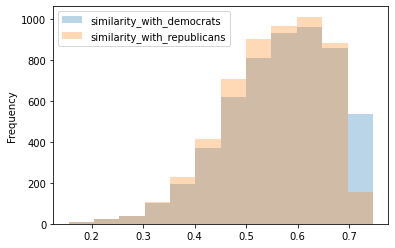

In [28]:
#plot distribution of similarity_with_democrats and similarity_with_republicans
speaker_embeddings[['similarity_with_democrats', 'similarity_with_republicans']].plot.hist(bins=12, alpha=0.3)

In our scenario we are interest at the following metrics:
- the similarity within parties
- the similarity between parties

We also calculate the 99% CI obtained by bootstrapping

To measure the similarity between parties, we calculate the mean over all Republicans, of the `similarity_with_democrats` column.

In [38]:
mean_rep_demo = speaker_embeddings.loc[rep_indices,'similarity_with_democrats'].mean()
mean_rep_demo_bootstrap = bootstrap((speaker_embeddings.loc[rep_indices,'similarity_with_democrats'],), np.mean, confidence_level=0.99)


print(f'mean: {mean_rep_demo}')
print(f'99% confidence interval: ({mean_rep_demo_bootstrap.confidence_interval.low}, {mean_rep_demo_bootstrap.confidence_interval.high})')

mean: 0.559647262096405
99% confidence interval: (0.5544832421227055, 0.5645479645926389)


To assess the similarity within Republicans, we calculate the mean over all Republicans of the `similarity_with_republicans` column

In [39]:
mean_rep_rep = speaker_embeddings.loc[rep_indices,'similarity_with_republicans'].mean()
mean_rep_rep_bootstrap = bootstrap((speaker_embeddings.loc[rep_indices,'similarity_with_republicans'],), np.mean)

print(f'mean: {mean_rep_rep}')
print(f'99% confidence interval: ({mean_rep_rep_bootstrap.confidence_interval.low}, {mean_rep_rep_bootstrap.confidence_interval.high})')

mean: 0.5474236011505127
99% confidence interval: (0.543790301668465, 0.5511143134938093)


To assess the similarity within Democrats, we calculate the mean over all Democrats of the `similarity_with_democrats` column

 

In [40]:
mean_demo_demo = speaker_embeddings.loc[demo_indices,'similarity_with_democrats'].mean()
mean_demo_demo_bootstrap = bootstrap((speaker_embeddings.loc[demo_indices,'similarity_with_democrats'],), np.mean)

print(f'mean: {mean_demo_demo}')
print(f'99% confidence interval: ({mean_demo_demo_bootstrap.confidence_interval.low}, {mean_demo_demo_bootstrap.confidence_interval.high})')

mean: 0.5770955681800842
99% confidence interval: (0.5730421377911975, 0.580949326443898)


We perform some ttest  to measure the degree of uncertanity of the following observations:
- the similarity within party is greater for democrats than for republicans.
- the inter-party similarity between republicans and democrats is greater than the similarity within republicans.
- the inter-party similarity between republicans and democrats is less than the similarity within democrats.

In [41]:
ttest_ind(speaker_embeddings.loc[rep_indices,'similarity_with_democrats'], speaker_embeddings.loc[rep_indices,'similarity_with_republicans'], alternative='greater')

Ttest_indResult(statistic=4.5093013537352356, pvalue=3.3221724030301274e-06)

In [42]:
ttest_ind(speaker_embeddings.loc[rep_indices,'similarity_with_democrats'], speaker_embeddings.loc[rep_indices,'similarity_with_republicans'], alternative='greater')

Ttest_indResult(statistic=4.5093013537352356, pvalue=3.3221724030301274e-06)

In [43]:
ttest_ind(speaker_embeddings.loc[rep_indices,'similarity_with_democrats'], speaker_embeddings.loc[demo_indices,'similarity_with_democrats'], alternative='less')

Ttest_indResult(statistic=-6.2589222305578955, pvalue=2.0865567780354368e-10)

Now let's take a look at the people that have over 70% similarity with republicans and democrats

In [29]:
# let's see who are the people that have over 70% similarity with republicans and democrats
reps_similar_to_demos = speaker_embeddings[(speaker_embeddings['similarity_with_democrats'] > 0.7) & (speaker_embeddings['party']=='Republican')][['similarity_with_democrats','qids', 'speaker', 'party', 'quotationCounts']]
demos_similar_to_demos = speaker_embeddings[(speaker_embeddings['similarity_with_democrats'] > 0.7) & (speaker_embeddings['party']=='Democrat')][['similarity_with_democrats','qids', 'speaker', 'party', 'quotationCounts']]


reps_similar_to_reps = speaker_embeddings[(speaker_embeddings['similarity_with_republicans'] > 0.7) & (speaker_embeddings['party']=='Republican')][['similarity_with_republicans','qids', 'speaker', 'party', 'quotationCounts']]
demos_similar_to_reps = speaker_embeddings[(speaker_embeddings['similarity_with_republicans'] > 0.7) & (speaker_embeddings['party']=='Democrat')][['similarity_with_republicans','qids', 'speaker', 'party', 'quotationCounts']]


Text(0.5, 1.0, 'Distribution of Similarity Values of \n most Similar Politicians to Republicans')

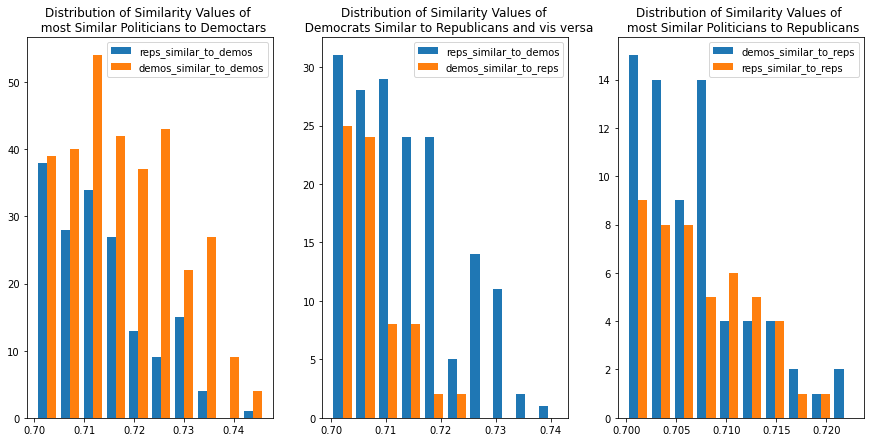

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
list_of_columns = [np.array(reps_similar_to_demos['similarity_with_democrats']), np.array(demos_similar_to_demos['similarity_with_democrats'] )]
axs[0].hist(list_of_columns, label = ['reps_similar_to_demos', 'demos_similar_to_demos'])
axs[0].legend()
axs[0].set_title('Distribution of Similarity Values of \n  most Similar Politicians to Democtars')

list_of_columns = [np.array(reps_similar_to_demos['similarity_with_democrats']), np.array(demos_similar_to_reps['similarity_with_republicans'] )]
axs[1].hist(list_of_columns, label = ['reps_similar_to_demos', 'demos_similar_to_reps'])
axs[1].legend()
axs[1].set_title('Distribution of Similarity Values of \n  Democrats Similar to Republicans and vis versa')

list_of_columns = [np.array(demos_similar_to_reps['similarity_with_republicans']), np.array(reps_similar_to_reps['similarity_with_republicans'] )]
axs[2].hist(list_of_columns, label = ['demos_similar_to_reps', 'reps_similar_to_reps'])
axs[2].legend()
axs[2].set_title('Distribution of Similarity Values of \n most Similar Politicians to Republicans')


# Check correlation between number of words and Similarity 

TODO ?

## **Topic Detection**

In [ ]:
# NOTE: Topic Detection might be more useful to use on all quotes to find other interesting topics such as climate change
# Transform quotes to list
climate_changes_quotes = df_climate_change['quotation'].tolist()
climate_change_quotes_dem = df_climate_change[df_climate_change['party']=='Q29552']['quotation'].tolist()
climate_change_quotes_rep = df_climate_change[df_climate_change['party']=='Q29468']['quotation'].tolist()

In [ ]:
nlp = spacy.load('en')

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_quotes = list()

# Do the pipeline for quotes by Democrats
for quote in nlp.pipe(climate_change_quotes_dem, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = quote.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    quote = [token.lemma_ for token in quote if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    quote = [token for token in quote if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    quote.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_quotes.append(quote)
climate_change_quotes_dem = processed_quotes
del processed_quotes

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

In [ ]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to quotes (only ones that appear 15 times or more).
bigram = Phrases(climate_change_quotes_dem, min_count=15)

for idx in range(len(climate_change_quotes_dem)):
    for token in bigram[climate_change_quotes_dem[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            climate_change_quotes_dem[idx].append(token)

In [ ]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(climate_change_quotes_dem)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(quote) for quote in climate_change_quotes_dem]
# MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 8167
Number of chunks: 35791


In [ ]:
# Models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [ ]:
model.show_topic(1,20)

[('climate', 0.06495684),
 ('change', 0.04831299),
 ('climate_change', 0.043356713),
 ('think', 0.010458426),
 ('people', 0.010312277),
 ('issue', 0.008132417),
 ('know', 0.0068965433),
 ('world', 0.0065764673),
 ('global', 0.0064074425),
 ('come', 0.006034373),
 ('like', 0.005913634),
 ('thing', 0.00558282),
 ('right', 0.0053323573),
 ('time', 0.0052455566),
 ('want', 0.005122252),
 ('real', 0.0050819917),
 ('year', 0.004848215),
 ('need', 0.0047712107),
 ('science', 0.004747436),
 ('atmosphere', 0.004597012)]

In [ ]:
# Plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

## **Semantic Analysis Based on Lexical Categories**

In [ ]:
lexicon = Empath()

# 194 different categories
print(str(len(list(lexicon.cats.keys()))) + " different categories")

# List the categories
print("\nExamples of these categories: ")
for cat in list(lexicon.cats.keys())[:10]:
    print(cat)

empath_cats = ["help", "nervousness", "horror", "optimism", "fear", "science", "sadness", "anger", "disappointment", "negative_emotion", "positive_emotion"]

In [ ]:
empath_features_dem = lexicon.analyze(climate_change_quotes_dem, categories = empath_cats, normalize = True)
empath_features_rep = lexicon.analyze(climate_change_quotes_rep, categories = empath_cats, normalize = True)

In [ ]:
empath_features_dem

In [ ]:
empath_features_rep

In [ ]:
# Create new lexical category that can be used to compare subgroups against
# e.g., here climate change
lexicon.create_category("climate_change", ["climate_change"], model="nytimes")